# Deloitte Quantum Challenge 2023

# =============================

# 0. References and credits

## Team: Quantux

- V00 20230317 - JW - Phase 1: Establishment
- V01 20230226 - JW - Phase 1: Add various local & realtime VQE client
- V02 20230301 - JW - Phase 1: Add decorators and modularise pipeline (Fix decorators later)
- V03 20230308 - JW - Phase 1: Fix optimizers, add runtime providers, add fake providers


## References:
### Python functions
- https://dev.to/kcdchennai/python-decorator-to-measure-execution-time-54hk

### Machine Learning modules
- https://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1

### Qiskit with latest post-migration modules and functions
- https://github.com/PacktPublishing/Quantum-Chemistry-and-Computing-for-the-Curious/blob/main/Chapter_05_Variational_Quantum_Eigensolver_.VQE._algorithm_V2.ipynb

- https://qiskit.org/documentation/nature/_modules/qiskit_nature/second_q/
- https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
- https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html
- https://qiskit.org/documentation/nature/tutorials/05_problem_transformers.html

### Qiskit realtime IBQM providers
- https://qiskit.org/documentation/stubs/qiskit.providers.ibmq.AccountProvider.html
- https://qiskit.org/documentation/partners/qiskit_ibm_provider/tutorials/Migration_Guide_from_qiskit-ibmq-provider.html
- https://quantumcomputing.stackexchange.com/questions/17375/is-there-any-way-to-obtain-the-number-of-qubits-of-a-given-backend-in-qiskit
- https://qiskit.org/documentation/apidoc/providers_fake_provider.html
- https://qiskit.org/documentation/tutorials/algorithms/02_vqe_advanced_options.html
- https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/Error-Suppression-and-Error-Mitigation.html
- https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html

- https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-mitigation.html
- https://qiskit.org/documentation/stubs/qiskit.transpiler.passes.DynamicalDecoupling.html

- Options - resilience level: No error mitigation
- Options - optimization level: 

### Distance: dist on metal ion + gas molecule


# =============================

# 1. Import libraries and qiskit functions

In [1]:
# 0. Data science & ML libraries
# =============================
import pandas as pd
import numpy as np
import warnings, os, time
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings('ignore')

from functools import wraps
from qiskit.utils import algorithm_globals

from functools import partial
from scipy.optimize import minimize

_SEED = 5
np.random.seed(_SEED)
algorithm_globals.random_seed = _SEED

In [2]:
# All are post-migration imports, ie. qiskit_nature == 0.5.0
import qiskit, qiskit_nature
v_qiskit = qiskit.__version__
v_qiskit_nature = qiskit_nature.__version__

if (v_qiskit >= '0.22') and (v_qiskit_nature >= '0.5'):
    
    # 1. Load qiskit account & providers
    # =============================
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='deloitte-event23', group='level-1-access', project='quantux')
    deloitte_provider = provider
    # deloitte_simulators = []
    from qiskit.providers.fake_provider import FakeProvider
    # from qiskit.providers.fake_provider import FakeVigo
    # from qiskit.test.mock import FakeProvider
    fake_provider = FakeProvider()
    
    # provider.backends() # List all backend providers
    qasm_simulator = provider.get_backend('ibmq_qasm_simulator')
    statevector_simulator = provider.get_backend('simulator_statevector')
    
    from qiskit.providers.aer import StatevectorSimulator
    from qiskit import Aer
    from qiskit_aer.noise import NoiseModel
    
    from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session
    

    # 2. Molecule & backend definition
    # =============================
    from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
    from qiskit_nature.units import DistanceUnit
    from qiskit.utils import QuantumInstance
    from qiskit_nature.second_q.drivers import PySCFDriver

    # VQE Client seem can't be used, use VQE instead
    # from qiskit_nature.runtime import VQEClient
    
    
    # 3. Estimators & Sampler Primitives
    # =============================
    from qiskit.primitives import Estimator, Sampler # Noiseless
    from qiskit_aer.primitives import Estimator as AerEstimator # Noisy
    
    
    # 4. Ansatz, initial circuit libraries, initial points (Ansatz parameters)
    # =============================
    from qiskit_nature.second_q.circuit.library import UCC, UCCSD, PUCCD, SUCCD, UVCCSD # Ansatz
    from qiskit_nature.second_q.circuit.library import HartreeFock # Initial State
    from qiskit.circuit.library import TwoLocal, PauliTwoDesign, EfficientSU2, RealAmplitudes, ExcitationPreserving # Initial Circuit
    from qiskit.quantum_info import Pauli
    #from qiskit.circuit.library.initial_states import hartree_fock, fermionic_gaussian_state, vscf
    #from qiskit.circuit.library.initial_points import mp2_initial_point, hf_initial_point, mp2_initial_point, vscf_initial_point
    
    
    # 5. Qubit Mappers & transformers
    # =============================
    from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, BravyiKitaevMapper, ParityMapper
    from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer
    
    
    # 6. Algorithms & optimizers
    # =============================
    from qiskit_nature.second_q.algorithms import NumPyMinimumEigensolverFactory, VQEUCCFactory, VQEUVCCFactory
    from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
    from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
    from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA, QNSPSA

    from qiskit.algorithms import HamiltonianPhaseEstimation, PhaseEstimation
    from qiskit.opflow import StateFn, PauliExpectation, CircuitSampler, PauliTrotterEvolution

else:
    print('Qiskit version not mostly updated - v2. Need updates before continue.')
    pass

# =============================

# 2. Define construct problem modules

# 2-0. Decorators

In [3]:
# Timeit decorator
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__} took {total_time:.4f} seconds to run\n')
        return result
    return timeit_wrapper


In [4]:
# Try except decorator
def get_err_msg_silent(value):
    def decorate(f):
        def applicator(_silent = False, *args, **kwargs):
            try:
                if not _silent:
                    print('{}: Loading...'.format(f.__name__))
                
                res = f(*args,**kwargs)
                
                if not _silent:
                    print('Success in loading {}'.format(f.__name__))
                return res
                
            except:
                if not _silent:
                    print('Fail in loading {}'.format(f.__name__))
                return value
        return applicator
    return decorate

In [5]:
# Try except decorator
def get_err_msg(value):
    def decorate(f):
        def applicator(*args, **kwargs):
            try:
                print('{}: Loading...'.format(f.__name__))
                res = f(*args,**kwargs)
                return res
            except:
                return value
        return applicator
    return decorate

In [121]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session as RuntimeSession,
                                Estimator as RuntimeEstimator, Options)
from qiskit import Aer

# service = QiskitRuntimeService(channel='ibm_quantum')
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='deloitte-event23/level-1-access/quantux',
)

backend_real = 'ibm_lagos'

import signal, time

from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')

from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None, init_data=[]):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        self._init_data = init_data
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            #print("EstimatorJob:", job.job_id())
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            #print("Job Value:", job.job_id(), value)
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        if len(self._init_data) > 0:
            x0 = init_data
        else:
            x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result


class RetryEstimator(RuntimeEstimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = RuntimeSession(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

# 2-1. Define modular functions

In [7]:
# Get a random FakeProvider from IBM runtime
def _0_get_min_runtime_provider(provider, min_qubits):
    
    # fake_provider = FakeProvider()
    # deloitte_provider = IBMProvider(instance="deloitte-event23/level-1-access/quantux")
    try:
        provider_list = [[b.configuration().n_qubits, b.name()] for b in provider.backends() if b.configuration().n_qubits >= min_qubits] # Usable in Aer
    except:
        provider_list = [[b.configuration().n_qubits, b.name] for b in provider.backends() if b.configuration().n_qubits >= min_qubits] # Usable in FakeProvider

    from collections import defaultdict
    provider_dict = defaultdict(list)
    for k, v in provider_list:
        provider_dict[k].append(v)

    provider_dict = dict(provider_dict)

    min_qubit = min(i for i in list((provider_dict.keys())) if i > min_qubits)

    provider_list_chosen = provider_dict[min_qubit]
    idx = np.random.randint(len(provider_list_chosen)) # Random choose provider with equivalent qubit computing size
    provider_out=provider_list_chosen[idx]

    print('Noisy Aer provider with min_qubit chosen: {}, {}'.format(min_qubit, provider_out))

    return provider_out

#_0_get_min_runtime_provider(provider, min_qubits = 5) # Deloitte provider / IBM main provider
#_0_get_min_runtime_provider(fake_provider, min_qubits = 5)

In [58]:
# 1. Get problem driver
#@get_err_msg('')
#@timeit
def _1_get_problem_driver(display_dict, input_value, basis = 'sto3g', input_type = 'molecule'):
    
    # =============================
    # 1. Define Molecule dictionary and return problem from PySCFDriver
    # =============================
    
    # =============================
    if input_type == 'molecule':
        moleculeinfo = MoleculeInfo(symbols = input_value['symbols'], coords = input_value['coords'], masses = input_value['masses'], 
                                    charge = input_value['charge'], multiplicity = input_value['multiplicity'])
    
    elif input_type == 'moleculeinfo':
        moleculeinfo = input_value
    
    driver = PySCFDriver.from_molecule(moleculeinfo, basis=basis)
    problem = driver.run()
    
    
    if display_dict is not None and input_type != 'moleculeinfo':
        display_dict['molecule'] = '{}'.format(input_value['symbols'])
        display_dict['charge'] = '{}'.format(input_value['charge'])
        display_dict['multiplicity'] = '{}'.format(input_value['multiplicity'])
        
        display_dict['reference_energy'] = '{}'.format(problem.reference_energy)
        display_dict['num_spin_orbitals'] = '{}'.format(problem.num_spin_orbitals)
        display_dict['num_spatial_orbitals'] = '{}'.format(problem.num_spatial_orbitals)
        display_dict['num_particles'] = '{}'.format(problem.num_particles)
        display_dict['nuclear_repulsion_energy'] = '{}'.format(problem.nuclear_repulsion_energy)
        display_dict['num_alpha'] = '{}'.format(problem.num_alpha)
        display_dict['num_beta'] = '{}'.format(problem.num_beta)
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
    
    return problem, display_dict_new

In [109]:
# 1. Get transform problem
#@get_err_msg('')
#@timeit
def _2_get_problem_transform(display_dict, problem, input_value, reduced):
    
    # =============================
    # 2. Transform the problem to reduce simulation space
    # =============================
    
    # =============================
    # If enter gas_molecules info, can transform; else if enter molecularinfo info, can not transform (should have previously transformed)
    
    # Problem reduction
    if reduced == 'FreezeCore':
        try:
            fc_transformer = FreezeCoreTransformer(freeze_core = input_value['fc_transformer']['fc_freeze_core'], 
                                                   remove_orbitals = input_value['fc_transformer']['fc_remove_orbitals'])
            problem = fc_transformer.transform(problem)
            display_chosen = input_value['fc_transformer']['fc_remove_orbitals']
        except:
            #print('FreezeCore Transformer did not succeed.')
            if display_dict is not None:
                display_dict['FreezeCoreTransformer'] = 'error'
                display_chosen = 'error'
            pass
        
        # How to determine which orbitals to be removed
        # https://quantumcomputing.stackexchange.com/questions/17852/use-one-body-integrals-to-know-which-orbitals-to-freeze-in-electronicstructurepr
        # https://www.youtube.com/watch?v=3B04KB0pDwE&t=667s
        
    elif reduced == 'ActiveSpace':
        #max_num_spatial_orbitals = problem.num_spatial_orbitals
        #max_num_electrons = problem.num_electrons
        #max_active_orbitals = itertools.combinations(max_num_spatial_orbitals, 2)
        # Use optuna to setup objective
        
        try:
            as_transformer = ActiveSpaceTransformer(num_electrons = input_value['as_transformer']['as_num_electrons'], 
                                                    num_spatial_orbitals = input_value['as_transformer']['as_num_spatial_orbitals'], 
                                                    active_orbitals = input_value['as_transformer']['as_active_orbitals'])
            problem = as_transformer.transform(problem)
            display_chosen = input_value['as_transformer']['as_active_orbitals']
        except:
            #print('ActiveSpace Transformer did not succeed.')
            if display_dict is not None:
                display_dict['ActiveSpaceTransformer'] = 'error'
                display_chosen = 'error'
            pass
    else:
        # print('Expect lengthy simulation if can not succeed in reducing orbitals using FreezeCoreTransformer or ActiveSpaceTransformer.')
        display_chosen = ''
        pass
    
    
    if display_dict is not None:
        display_dict['reduction_method'] = '{}'.format(reduced)
        display_dict['orbitals_removed'] = '{}'.format(display_chosen)
        display_dict_new = display_dict
        #print("_2_get_problem_transform", display_dict_new)
    else:
        display_dict_new = display_dict
    
    return problem, display_dict_new

In [10]:
# 3. Get qubit operator
#@get_err_msg('')
#@timeit
def _3_get_qubit_operator(display_dict, problem, hyperparam, mapper_type):
    
    # =============================
    # 3. Define qubit mapping and convert to qubit operator
    # =============================
    
    # =============================
    # Qubit mapping
    if mapper_type == 'ParityMapper':
        mapper = ParityMapper()
    elif mapper_type == 'JordanWignerMapper':
        mapper = JordanWignerMapper()
    elif mapper_type == 'BravyiKitaevMapper':
        mapper = BravyiKitaevMapper()
    
    fermionic_hamiltonian = problem.hamiltonian
    second_q_op = fermionic_hamiltonian.second_q_op()
    
    num_particles = problem.num_particles
        
    qubit_converter = QubitConverter(mapper, 
                                     two_qubit_reduction = hyperparam['two_qubit_reduction'], 
                                     z2symmetry_reduction = hyperparam['z2symmetry_reduction'])
    qubit_op = qubit_converter.convert(second_q_op, num_particles = num_particles, sector_locator = problem.symmetry_sector_locator)
    
    
    if display_dict is not None:
        display_dict['second_q_op'] = '{}'.format("\n".join(str(second_q_op).splitlines()[:10] + ["..."]))
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
        
    return qubit_op, qubit_converter, display_dict_new

In [11]:
# 4. Get quantum problem solver
#@get_err_msg('')
#@timeit
def _4_get_ansatz(display_dict, problem, hyperparam, qubit_op, qubit_converter, seed, randomize = False):
    
    # =============================
    # 4. Define various solver types with initalizing the ansatz or initial circuit
    # =============================
    
    # =============================
    num_spin_orbitals = problem.num_spin_orbitals
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    num_qubits = qubit_op.num_qubits
    
    # i. List of ansatz
    # [UCCSD(), UCC(), PUCCD(), SUCCD(), UVCCSD()] # Others like PUCCD needs alpha == beta, ie. lots of restrictions thus all except UCCSD are left unused
    ansatz_hf = HartreeFock(num_qubits, num_particles, qubit_converter)
    
    ansatz_uccsd = UCCSD(num_spatial_orbitals,
                         num_particles,
                         qubit_converter,
                     initial_state=ansatz_hf)
    
    ansatz_lst = [ansatz_uccsd]
    ansatz_name = ['UCCSD']
    
    # =============================
    # ii. For QNSPSA, must match num_qubits to the circuit observable, currently H2 is 4, use this constraint to subordinate for num_qubits' design from initial_circuits
    
    circuit_tl = TwoLocal(num_qubits, rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz', entanglement='full', reps=hyperparam['reps'], parameter_prefix = 'y')
    circuit_su2 = EfficientSU2(num_qubits, reps=hyperparam['reps'], entanglement="full")
    circuit_p2d = PauliTwoDesign(num_qubits, reps=hyperparam['reps'], seed=seed)
    circuit_ra = RealAmplitudes(num_qubits, reps=hyperparam['reps'])
    circuit_ep = ExcitationPreserving(num_qubits, entanglement = 'full', reps=hyperparam['reps'], mode = 'iswap')
    
    initial_circuit_lst = [circuit_tl, circuit_su2, circuit_p2d, circuit_ra, circuit_ep]
    initial_circuit_name = ['TwoLocal', 'EfficientSU2', 'PauliTwoDesign', 'RealAmplitudes', 'ExcitationPreserving']
    
    if randomize:
        idx_ansatz = np.random.randint(len(ansatz_lst))
        ansatz_chosen = ansatz_lst[idx_ansatz]
        
        idx_initial_circuit = np.random.randint(len(initial_circuit_lst))
        initial_circuit_chosen = initial_circuit_lst[idx_initial_circuit]
    else:
        idx_ansatz = ansatz_name.index(hyperparam['ansatz'])
        an = hyperparam['ansatz']
        an_val = np.where(np.array(ansatz_name) == an)[0][0]
        ansatz_chosen = ansatz_lst[an_val]
        
        ic = hyperparam['initial_circuit']
        ic_val = np.where(np.array(initial_circuit_name) == ic)[0][0]
        initial_circuit_chosen = initial_circuit_lst[ic_val]
        idx_initial_circuit = ic_val
        #print(ansatz_chosen, initial_circuit_chosen)
    
    if display_dict is not None:
        display_dict['ansatz_chosen'] = ansatz_name[idx_ansatz]
        display_dict['initial_circuit_chosen'] = initial_circuit_name[idx_initial_circuit]
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
    
    return ansatz_chosen, initial_circuit_chosen, display_dict_new

In [12]:
# 5. Get optimizer
#@get_err_msg('')
#@timeit
def _5_get_solver_optimizer(display_dict, problem, hyperparam, qubit_op, qubit_converter, solver_type, ansatz_chosen, initial_circuit_chosen, optimizer, method):
    
    # =============================
    # 5. Define VQE solvers to solve for PES in quantum chemistry
    # =============================
    
    # a. Optimizer set
    # [SPSA(maxiter=100), SLSQP(maxiter=100)] + [partial(minimize, method=i) for i in method_lst]
    # =============================
    method_lst = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr']
    opt = [partial(minimize, method=i) for i in method_lst]

    optimizer_lst = [SPSA(maxiter=1), SLSQP(maxiter=1), COBYLA(maxiter=100)] + opt
    optimizer_name = ['SPSA', 'SLSQP', 'COBYLA'] + ['minimize_{}'.format(i) for i in method_lst]
    
    optimizer_dict = dict(zip(optimizer_name, optimizer_lst))
    optimizer_chosen = optimizer_dict[optimizer]
    
    # Fixed solver and optimizers
    # ['vqe_qnspsa', 'vqe_simulator_noiseless', 'vqe_simulator_noisy_0_0', 'vqe_runtime_noiseless', 'vqe_runtime_noisy_0_0', 'vqe_fake_runtime_noiseless', 
    # 'vqe_fake_runtime_noisy_0_0', 'vqe_ansatz', 'numpy_solver_with_filter', 'numpy_solver', 'vqe_initial_circuit']
    # =============================
    if solver_type == 'vqe_qnspsa':
        ans = initial_circuit_chosen
        obs = qubit_op
        initial_point = np.random.random(ans.num_parameters)

        # loss function
        est = Estimator()

        def loss(x):
            result = est.run([ans], [obs], [x]).result()
            return np.real(result.values[0])

        # fidelity for estimation of the geometric tensor
        sam = Sampler()
        fidelity = QNSPSA.get_fidelity(ans, sam)

        # run QN-SPSA
        solver = QNSPSA(fidelity, maxiter=3000, perturbation = 0.7, learning_rate = 0.01)
        ground_state = solver.optimize(ans.num_parameters, loss, initial_point=initial_point)
        energy = ground_state[1]

    elif solver_type == 'vqe_simulator_noiseless':
        options = {'optimization_level': 3, 'resilience_level': 3}

        ans = initial_circuit_chosen
        opt = optimizer_chosen
        est = Estimator(options = options)

        solver = VQE(ansatz = ans, estimator = est, optimizer = opt)
        ground_state = solver.compute_minimum_eigenvalue(qubit_op)
        energy = ground_state.eigenvalue

    elif solver_type == 'vqe_simulator_noisy_0_0':
        options = {'optimization_level': 0, 'resilience_level': 0}

        ans = initial_circuit_chosen
        opt = optimizer_chosen
        est = Estimator(options = options)

        solver = VQE(ansatz = ans, estimator = est, optimizer = opt)
        ground_state = solver.compute_minimum_eigenvalue(qubit_op)
        energy = ground_state.eigenvalue

    elif solver_type == 'vqe_runtime_noiseless':
        # Other options available: options = {'optimization_level': 0-3, 'resilience_level': 0-3}
        ans = initial_circuit_chosen
        opt = optimizer_chosen

        device = provider.get_backend(_0_get_min_runtime_provider(provider = provider, min_qubits = qubit_op.num_qubits))
        coupling_map = device.configuration().coupling_map
        noise_model = None

        noisy_est = AerEstimator(backend_options={"method": "statevector", "coupling_map": coupling_map, "noise_model": noise_model,},
                                 run_options={"seed": _SEED, "shots": 1024, 'optimization_level': 3, 'resilience_level': 3},
                                 transpile_options={"seed_transpiler": _SEED},
                                )
        solver = VQE(noisy_est, ans, optimizer=opt)
        ground_state = solver.compute_minimum_eigenvalue(qubit_op)
        energy = ground_state.eigenvalue

    elif solver_type == 'vqe_runtime_noisy_0_0':
        # Other options available: options = {'optimization_level': 0-3, 'resilience_level': 0-3}
        ans = initial_circuit_chosen
        opt = optimizer_chosen

        device = provider.get_backend(_0_get_min_runtime_provider(provider = provider, min_qubits = qubit_op.num_qubits))
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)

        noisy_est = AerEstimator(backend_options={"method": "density_matrix", "coupling_map": coupling_map, "noise_model": noise_model,},
                                 run_options={"seed": _SEED, "shots": 1024, 'optimization_level': 0, 'resilience_level': 0},
                                 transpile_options={"seed_transpiler": _SEED},
                                )
        solver = VQE(noisy_est, ans, optimizer=opt)
        ground_state = solver.compute_minimum_eigenvalue(qubit_op)
        energy = ground_state.eigenvalue

    elif solver_type == 'vqe_fake_runtime_noiseless':
        # Other options available: options = {'optimization_level': 0-3, 'resilience_level': 0-3}
        provider = fake_provider
        ans = initial_circuit_chosen
        opt = optimizer_chosen

        device = provider.get_backend(_0_get_min_runtime_provider(provider = provider, min_qubits = qubit_op.num_qubits))
        coupling_map = device.configuration().coupling_map
        noise_model = None #NoiseModel.from_backend(device)

        noisy_est = AerEstimator(backend_options={"method": "density_matrix", "coupling_map": coupling_map, "noise_model": noise_model,},
                                 run_options={"seed": _SEED, "shots": 1024, 'optimization_level': 3, 'resilience_level': 3},
                                 transpile_options={"seed_transpiler": _SEED},
                                )
        solver = VQE(noisy_est, ans, optimizer=opt)
        ground_state = solver.compute_minimum_eigenvalue(qubit_op)
        energy = ground_state.eigenvalue

    elif solver_type == 'vqe_fake_runtime_noisy_0_0':
        # Other options available: options = {'optimization_level': 0-3, 'resilience_level': 0-3}
        provider = fake_provider
        ans = initial_circuit_chosen
        opt = optimizer_chosen

        device = provider.get_backend(_0_get_min_runtime_provider(provider = provider, min_qubits = qubit_op.num_qubits))
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)

        noisy_est = AerEstimator(backend_options={"method": "density_matrix", "coupling_map": coupling_map, "noise_model": noise_model,},
                                 run_options={"seed": _SEED, "shots": 1024, 'optimization_level': 0, 'resilience_level': 0},
                                 transpile_options={"seed_transpiler": _SEED},
                                )
        solver = VQE(noisy_est, ans, optimizer=opt)
        ground_state = solver.compute_minimum_eigenvalue(qubit_op)
        energy = ground_state.eigenvalue
        
    elif solver_type == 'vqe_runtime_test':
        ansatz = ansatz_chosen
        optimizer = SPSA(1)
        backend = hyperparam['backend']
        init_data = []
        #service_test = QiskitRuntimeService(channel='ibm_quantum')
        
        with RuntimeSession(service=service, backend=backend) as session:
            # Prepare extended primitive
            rt_estimator = RetryEstimator(session=session)
            # set up algorithm
            custom_vqe = CustomVQE(rt_estimator, ansatz, optimizer, callback=callback_real, init_data=init_data)
            # run algorithm
            result = custom_vqe.compute_minimum_eigenvalue(qubit_op)
            ground_state = result
            energy = result.eigenvalue

    elif solver_type == 'vqe_runtime_real':
        options_ZNE = Options()
        options_ZNE.execution.shots = 8900
        options_ZNE.optimization_level = 0 # no optimization
        options_ZNE.resilience_level = 2 # ZNE
        options_ZNE.resilience.noise_factors = [np.pi/2, (np.pi/2)*2, (np.pi/2)*3]
        options_ZNE.resilience.noise_amplifier = "LocalFoldingAmplifier"
        options_ZNE.resilience.extrapolator = "QuadraticExtrapolator"

        options = options_ZNE
        #options = None
        init_data = []
        ansatz = initial_circuit_chosen
        optimizer = SPSA(1)
        
        #start = time.time()
        with RuntimeSession(service=service, backend=backend_real) as session:
            # Prepare extended primitive
            rt_estimator = RetryEstimator(session=session, options=options)
            # set up algorithm
            custom_vqe = CustomVQE(rt_estimator, ansatz, optimizer, callback=callback_real, init_data=init_data)
            # run algorithm
            result = custom_vqe.compute_minimum_eigenvalue(qubit_op)
            ground_state = result
            energy = result.eigenvalue
        #end = time.time()
        #print(f'execution time (s): {end - start:.2f}')
        
    # Customizable solver and optimizers
    # =============================
    # Solvers
    elif solver_type == 'vqe_ansatz':
        est = Estimator()
        ans = ansatz_chosen
        opt = optimizer_chosen

        solver = VQEUCCFactory(est, ans, opt)

    elif solver_type == 'numpy_solver_with_filter':
        solver = NumPyMinimumEigensolverFactory(use_default_filter_criterion=True)

    elif solver_type == 'numpy_solver':
        solver = NumPyMinimumEigensolverFactory()

    elif solver_type == 'vqe_initial_circuit':
        est = Estimator()
        ic = initial_circuit_chosen
        opt = optimizer_chosen

        solver = VQE(est, ic, opt) 

    # Optimizers
    if method == 'gses':
        calc = GroundStateEigensolver(qubit_converter, solver)
        ground_state = calc.solve(problem)

        energy = ground_state.total_energies[0].real

    elif method == 'qpe':
        # Quantum Phase Estimation
        quantum_instance = QuantumInstance(backend = Aer.get_backend('aer_simulator_statevector'))
        evolution = PauliTrotterEvolution('trotter', reps = hyperparam['qpe_num_time_slices'])

        qpe = HamiltonianPhaseEstimation(hyperparam['qpe_n_ancilliae'], quantum_instance=quantum_instance)

        state_preparation = None
        # state_preparation = 
        ground_state = qpe.estimate(qubit_op, state_preparation, evolution=evolution)

        energy = ground_state.most_likely_eigenvalue


    
    # =============================
    
    if display_dict is not None:
        display_dict['solver'] = '{}'.format(solver_type)
        display_dict['optimizer'] = '{}'.format(optimizer)
        display_dict['solution_method'] = '{}'.format(method)
        
        display_dict_new = display_dict
    else:
        display_dict_new = display_dict
        
    return ground_state, energy, display_dict_new


# 2-2. Build construct pipeline

In [13]:
# Create construct problem
#@get_err_msg('')
#@timeit
def get_construct_problem(input_value, hyperparam, input_type, display_report, reduced, basis, mapper_type, solver_type, method, optimizer, seed, randomize=False):
    
    # =============================
    # 0. Display Report Dict
    # =============================
    if display_report == True:
        display_dict = {}
    else:
        display_dict = None
    
    # =============================
    # A. The quantum solver pipeline
    # =============================
    
    # Specify input_type = 'molecule' or 'moleculeinfo'
    problem, display_dict_1 = _1_get_problem_driver(display_dict, input_value, basis = basis, input_type = input_type)
    
    problem, display_dict_2 = _2_get_problem_transform(display_dict_1, problem, input_value, reduced)
    
    qubit_op, qubit_converter, display_dict_3 = _3_get_qubit_operator(display_dict_2, problem, hyperparam, mapper_type)
    
    ansatz_chosen, initial_circuit_chosen, display_dict_4 = _4_get_ansatz(display_dict_3, problem, hyperparam, qubit_op, qubit_converter, seed, randomize)
    
    ground_state, energy, display_dict_5 = _5_get_solver_optimizer(display_dict_4, problem, hyperparam, qubit_op, qubit_converter, 
                                                                   solver_type, ansatz_chosen, initial_circuit_chosen, optimizer, method)
    if display_report == True:
        display_df = pd.DataFrame.from_dict([display_dict_5])
    else:
        display_df = None
    
    return ground_state, energy, display_df


# ======================================

# 3-1. Calculate molecule energy by BOPES calculations with regressed distance

In [101]:
def get_a_molecule_perturbation_list(moleculeinfo, hyperparam, perturbation_steps):
    
    from copy import deepcopy
    
    EPSILON = 1e-3
    
    atom_pair = hyperparam['atom_pair']
    pair_0, pair_1 = atom_pair
    
    x0, y0, z0 = moleculeinfo.coords[pair_0 - 1]
    x1, y1, z1 = moleculeinfo.coords[pair_1 - 1]
    # Get a straight line connecting the 2 interacting atom pair, y = mx + p
    m = 0
    p = y0
    if abs(x1 - x0) > EPSILON:
        m = (y1 - y0)/(x1 - x0)
        p = y0 - m*x0

    #print("coords:", len(moleculeinfo.coords), " ", x0, y0, z0, " - ", x1, y1, z1)
    # This perturbation assumes lying on the same plane
    size = len(perturbation_steps)
    energy_lst = np.empty(size)
    
    perturbation_lst = []
    for k in range(size):
        # print("Step: ", k)
        
        if (abs(x0) < EPSILON and abs(y0) < EPSILON):
            z0_new = z0 + perturbation_steps[k]
            
            coords_new = []
            for l in range(len(moleculeinfo.coords)):
                #print("Add Z ",l)
                if l == atom_pair[0]:
                    coords_new.append((0.0, 0.0, z0_new))
                else:
                    coords_new.append(moleculeinfo.coords[l])
        
        elif (abs(z0) < EPSILON and abs(z1) < EPSILON):
            x0_new = x0 + perturbation_steps[k]
            y0_new = m*x0_new + p
            
            coords_new = []
            for l in range(len(moleculeinfo.coords)):
                #print("Add XY ",l)
                if l == atom_pair[0]:
                    coords_new.append((x0_new, y0_new, 0.0))
                else:
                    coords_new.append(moleculeinfo.coords[l])
                    
        else:
            print("bopes - Error: unsupported molecule geometry, atom pairs must be in the same line or in the same plane")
            return perturbation_steps, 0
    
        moleculeinfo_new = deepcopy(moleculeinfo)
        moleculeinfo_new.coords = coords_new
        
        perturbation_lst.append(moleculeinfo_new)
        
    return perturbation_lst

In [102]:
# Get BOPES energy curve

def get_a_molecule_bopes(input_value, hyperparam, input_type = 'molecule',
                       reduced = 'ActiveSpace', basis = 'sto3g', mapper_type = 'JordanWignerMapper', solver_type = 'numpy_solver', method = 'gses', 
                       perturbation_steps = np.linspace(0.5, 3, 250), optimizer = 'SLSQP', display_report = False, seed = _SEED, randomize = False):
    
    # Obtain molecule coordinates
    # ===========================
    EPSILON = 1e-3
    
    if input_type == 'molecule':
        moleculeinfo = MoleculeInfo(symbols = input_value['symbols'], coords = input_value['coords'], masses = input_value['masses'], 
                                    charge = input_value['charge'], multiplicity = input_value['multiplicity'])
    
    elif input_type == 'moleculeinfo':
        moleculeinfo = input_value
    
    perturbation_lst = get_a_molecule_perturbation_list(moleculeinfo, hyperparam, perturbation_steps)
    
    energy_lst = []
    for k in tqdm(range(len(perturbation_lst)), position = 0, leave = True):
        
        tmp_moleculeinfo = perturbation_lst[k]
        #print("tmp_moleculeinfo", tmp_moleculeinfo)
        input_value["coords"] = tmp_moleculeinfo.coords
        # Get ground state energy from construct problem
        # ===========================
        _, tmp_energy, _ = get_construct_problem(input_value, hyperparam, input_type, display_report, reduced, basis, mapper_type, solver_type, method, optimizer, seed, randomize)
        energy_lst.append(tmp_energy)
        
    if display_report:
        from matplotlib import pyplot as plt
        %matplotlib inline
        plt.rcParams["figure.figsize"] = [10, 10]
        plt.rcParams["figure.autolayout"] = True
        
        df = pd.DataFrame(list(zip(energy_lst, perturbation_steps)), columns = ['energy', 'step'])
        fig, ax = plt.subplots(facecolor='lightslategray')
        ax.set_clip_on(False)
        df.plot(kind='scatter', x='step', y='energy', ax=ax, color='black', linewidth=0, label = 'VQE Energy (HF)')
        
        e_min = min(energy_lst)
        p_min = perturbation_steps[energy_lst == e_min]
        print('Molecule energy:{} with atoms separated at {} apart'.format(e_min, p_min))
        
    return perturbation_steps, energy_lst


# Load Quantistry coordinates for comparison

In [103]:
import pandas as pd
import numpy as np
from zipfile import *
import warnings, os, gzip
warnings.filterwarnings('ignore')
pth = os.getcwd() + r'/quantistry'

def get_coord(zip_file):
    all_res = []

    with ZipFile(zip_file, 'r') as f:
        coord_list = [x for x in f.namelist() if 'csv' not in x]
        for i in coord_list:
            tmp = f.extract(i)
            df = pd.read_csv(tmp)

            new_df = []
            for j in range(len(df)):
                df.iloc[j] = df.iloc[j].str.replace('  ', ' ', regex = True)
                new_df.append(df.iloc[j].str.split(' ', expand = True))

            new_df = pd.concat(new_df)
            
            new_df0 = pd.DataFrame(['{}'.format(i).replace('.xyz', '')] * len(new_df), columns = ['step'])
            
            new_df1 = new_df.iloc[:, 0].reset_index(drop = True)
            
            new_df2 = new_df.iloc[:, 1:]
            out = pd.DataFrame(new_df2.iloc[:,::-1].apply(lambda x: x.dropna().tolist(), axis=1).tolist(), columns=new_df2.columns[::-1]).iloc[:,::-1]
            out.replace('', float('NaN'), inplace = True)
            out.dropna(axis = 1, how = 'all', inplace = True)

            final = pd.concat([new_df0, new_df1, out], axis = 1)
            final.columns = ['step', 'atom', 'x', 'y', 'z']
            bohr2ang = 0.52917721092            
            final[['x', 'y', 'z']] = final[['x', 'y', 'z']].astype(float) * bohr2ang
            all_res.append(final)

        f.close()
        
    return pd.concat(all_res)


In [104]:
#testing the function get_coord after converting the units to angstrom
df = get_coord(pth + r'/Co2_CO2.zip')
df.head()

,step,atom,x,y,z
0,step_000,Co,3.622064,3.054776,2.645886
1,step_000,O,4.354197,3.361444,2.645886
2,step_000,C,4.917498,3.610078,2.645886
3,step_000,O,5.462803,3.850635,2.645886
0,step_001,Co,3.579621,3.036998,2.645886


In [105]:
def getCoordinate(data, step, size):
    mol_start = step*size
    mol = data.get("atom").values[mol_start:mol_start + size]
    #print(data, dir(mol), mol)
    coords = []
    for size_start in range(mol_start,mol_start + size):
        coordx = float(data.get("x")[size_start:size_start+1].values[:1].real[0])
        coordy = float(data.get("y")[size_start:size_start+1].values[:1].real[0])
        coordz = float(data.get("z")[size_start:size_start+1].values[:1].real[0])

        coords.append([coordx,coordy,coordz])
    return mol, coords

In [106]:
def getCoordinateQuantistryToBOPES(coords):
    for i in range(len(coords)):
        coords[i][2] = 0
    return coords


# 3-2. Calculate molecule energy by BOPES calculations with Variable MOF atomic distance relative to gas molecule

In [107]:
def run_VQE_BOPES_Energies(molecule_name, multiplicity, charge, masses, atom_pair = (1, 0), freeze_remove=None, run_real=False, perturbation_steps = np.linspace(0.5, 3.0, 150), optimizer = 'COBYLA'):
    # ===
    step = 0
    molecule_data = get_coord(pth + r'/'+molecule_name+'.zip')
    mol, coords = getCoordinate(molecule_data, step, len(masses))
    bopesCoords = getCoordinateQuantistryToBOPES(coords)
    
    gas_molecules = {
        molecule_name: {'symbols': mol,
               'coords': coords,
               'multiplicity': multiplicity,
               'charge': charge,
               'units': DistanceUnit.ANGSTROM,
               'masses': masses,
               'atom_pair': atom_pair, # not available after migration
               'fc_transformer': {
                   'fc_freeze_core': True, 
                   'fc_remove_orbitals': freeze_remove, 
                   },
    #           'as_transformer': {
    #               'as_num_electrons': 0,
    #               'as_num_spatial_orbitals': 2,
    #               'as_active_orbitals': [1, 1],
    #               }
               }
    }

    hyperparameters = {
        molecule_name: {'reps': 2,
               'two_qubit_reduction': True,
               'z2symmetry_reduction': 'auto',
               'perturbation_steps': perturbation_steps,
               'qpe_num_time_slices': 1,
               'qpe_n_ancilliae': 3,
               'atom_pair': atom_pair, # index start from 1
               'optimizer': optimizer,
               'ansatz': 'UCCSD',
               'initial_circuit': 'PauliTwoDesign',
              },

    }

    # ===
    input_value = gas_molecules[molecule_name]
    hyperparam = hyperparameters[molecule_name]
    input_type = 'molecule'
    display_report = True
    display_dict = {}
    reduced = 'FreezeCore'
    basis = 'sto3g'
    mapper_type = 'JordanWignerMapper'
    solver_type = 'numpy_solver'
    method = 'gses'
    seed = _SEED
    _, energy, display_df = get_construct_problem(input_value, hyperparam, input_type, display_report, 
                                                  reduced, basis, mapper_type, solver_type, method, optimizer, seed)
    display(display_df)
    perturb_steps, energy_lst = get_a_molecule_bopes(input_value = input_value, hyperparam = hyperparam, 
                                                     input_type = input_type, reduced = reduced, basis = basis, 
                                                     mapper_type = mapper_type, 
                                                     solver_type = solver_type, method = method, 
                                                     perturbation_steps = perturbation_steps, 
                                                     optimizer = optimizer, display_report = True, seed = _SEED)
    return perturb_steps, energy_lst

,molecule,charge,multiplicity,reference_energy,num_spin_orbitals,num_spatial_orbitals,num_particles,nuclear_repulsion_energy,num_alpha,num_beta,reduction_method,orbitals_removed,second_q_op,ansatz_chosen,initial_circuit_chosen,solver,optimizer,solution_method
0,['Fe' 'O' 'C' 'O'],2,1,-1421.025404094263,66,33,"(23, 23)",363.9425938236083,23,23,FreezeCore,"range(13, 30)","Fermionic Operator\nnumber spin orbitals=8, nu...",UCCSD,PauliTwoDesign,numpy_solver,COBYLA,gses


100%|██████████| 20/20 [01:43<00:00,  5.20s/it]


Molecule energy:-1425.8659930072063 with atoms separated at [1.34210526] apart


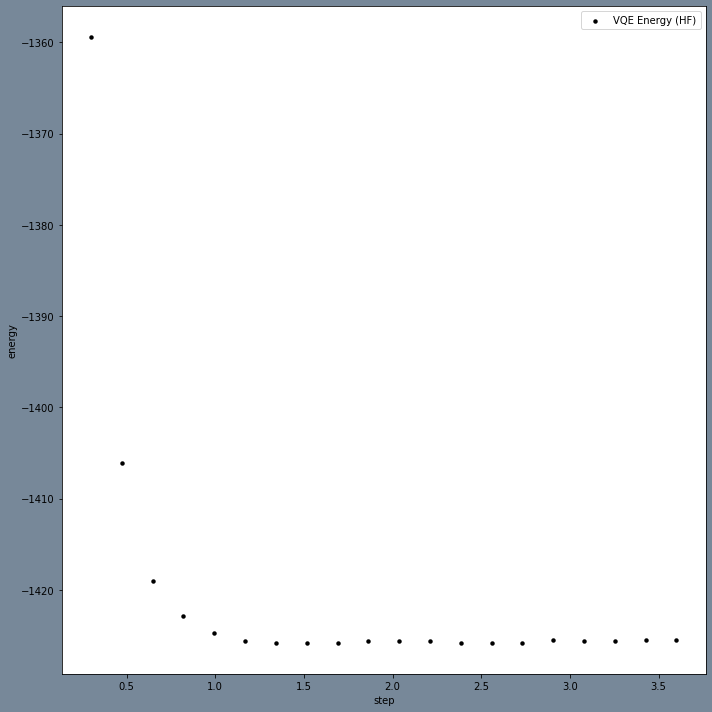

In [112]:
run_VQE_BOPES_Energies(molecule_name='Fe2_CO2',multiplicity=1,charge=2,masses=[56, 1, 16, 1], 
                       atom_pair = (0,1), freeze_remove=range(13,30), run_real = False, 
                       perturbation_steps = np.linspace(0.3, 3.6, 200), optimizer = 'COBYLA');

# 3-3. Unittest for molecule energy from different parameter combinations

In [147]:
# ===
gas_molecules = {
    'h2': {'symbols': ["H", "H"],
           'coords': [(0.0000, 0.0000, 0.0000),
                      (0.0000, 0.0000, 0.7414)],
           'multiplicity': 1,
           'charge': 0,
           'units': DistanceUnit.ANGSTROM,
           'masses': [1, 1],
           # 'atom_pair': (1, 2), # not available after migration
           'fc_transformer': {
               'fc_freeze_core': True, 
               'fc_remove_orbitals': None,
               },
           'as_transformer': {
               'as_num_electrons': 0,
               'as_num_spatial_orbitals': 2,
               'as_active_orbitals': [1, 1],
               }
           }
}

hyperparameters = {
    'h2': {'reps': 2,
           'two_qubit_reduction': True,
           'z2symmetry_reduction': 'auto',
           'perturbation_steps': np.linspace(0.5, 4.0, 250),
           'qpe_num_time_slices': 1,
           'qpe_n_ancilliae': 3,
           'atom_pair': (1, 2), # index start from 1
           'optimizer': 'SLSQP',
           'ansatz': 'UCCSD',
           'initial_circuit': 'PauliTwoDesign',
           'qnspsa_pertubation': 0.7,
           'qnspsa_learning_rate': 0.01,
          },

}

solution_master = {
    'classical': ['numpy_solver', 'numpy_solver_with_filter'],
    'quantum': ['vqe_qnspsa', 'vqe_runtime', 'vqe_runtime_with_noise', 'vqe_ansatz', 'vqe_ansatz', 'vqe_initial_circuit']
}

# ===
molecule = gas_molecules['h2']
hyperparam = hyperparameters['h2']
# display_report = False
display_dict = {}
basis = 'sto3g'


In [148]:
lst_mapper_type = ['JordanWignerMapper']
# lst_reduced = ['FreezeCore', 'ActiveSpace', '']
lst_reduced = ['FreezeCore']

# method_lst = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr']
# lst_optimizer = ['SPSA', 'SLSQP'] + ['minimize_{}'.format(i) for i in method_lst]
# lst_optimizer = ['SPSA', 'SLSQP']
lst_optimizer = ['SPSA']

# lst_solver_type = ['vqe_qnspsa', 'vqe_runtime_noiseless', 'vqe_runtime_noisy_0', 'numpy_solver_with_filter', 'numpy_solver', 'vqe_ansatz', 'vqe_initial_circuit']
lst_solver_type = ['vqe_fake_runtime_noiseless']

#lst_method = ['gses', 'qpe']
lst_method = ['gses']

#initial_circuit_name = ['TwoLocal', 'EfficientSU2', 'PauliTwoDesign', 'RealAmplitudes', 'ExcitationPreserving']
hyperparam['initial_circuit'] = 'RealAmplitudes'
# hyperparam['fake_provider'] = fake_provider

for a in lst_mapper_type:
    for b in lst_reduced:
        for c in lst_optimizer:
            for d in lst_solver_type:
                for e in lst_method:
                    tmp_ground_state, tmp_energy, _ = get_construct_problem(input_value = gas_molecules['h2'], hyperparam = hyperparameters['h2'], input_type = 'molecule', 
                                                             display_report = False, reduced = b, basis = basis, mapper_type = a, 
                                                             solver_type = d, method = e, optimizer = c, seed = _SEED, randomize = False)
                    print('{}|{}|{}|{}|{}: {}'.format(a, b, c, d, e, tmp_ground_state))
                    

1 OK
2 OK
3 OK
4 OK
Noisy Aer provider with min_qubit chosen: 2, fake_openpulse_2q
5 OK
JordanWignerMapper|FreezeCore|SPSA|vqe_fake_runtime_noiseless|gses: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.838130413569
  - computed part:      -1.838130413569
  - FreezeCoreTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 0.713753993688
> Total ground state energy (Hartree): -1.124376419881
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.40104295]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  None]
    - computed part:      [0.0  0.0  None]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  None]  Total: None
                 (debye): [0.0  0.0  None]  Total: None
 


# 4. Deployment

In [113]:
def runVQEEnergies(molecule_name, multiplicity, charge, masses, freeze_remove, run_real = False, max_range = 23, optimizer = 'COBYLA'):
    # ===
    exact_energies = []
    vqe_energies = []

    steps = range(0,max_range)
    for step in steps:
        #print("Starting step:", step, " VQE result:", vqe_energies)
        molecule_data = get_coord(pth + r'/'+molecule_name+'.zip')
        mol, coords = getCoordinate(molecule_data, step, len(masses))
        #print(mol, coords)

        gas_molecules = {
            molecule_name: {'symbols': mol,
                   'coords': coords,
                   'multiplicity': multiplicity,
                   'charge': charge,
                   'units': DistanceUnit.ANGSTROM,
                   'masses': masses,
                   #'atom_pair': (1, 2), # not available after migration
                   'fc_transformer': {
                       'fc_freeze_core': True, 
                       'fc_remove_orbitals': freeze_remove,
                       },
        #           'as_transformer': {
        #               'as_num_electrons': 0,
        #               'as_num_spatial_orbitals': 2,
        #               'as_active_orbitals': [1, 1],
        #               }
                   }
        }

        hyperparameters = {
            molecule_name: {'reps': 2,
                   'two_qubit_reduction': True,
                   'z2symmetry_reduction': None,
                   'backend': 'qasm_simulator', #qasm_simulator
                   'optimizer': 'SLSQP',
                   'ansatz': 'UCCSD',
                   'initial_circuit': 'EfficientSU2',
                  },

        }


        # ===
        molecule = gas_molecules[molecule_name]
        hyperparam = hyperparameters[molecule_name]
        optimizer = optimizer
        # display_report = False
        display_dict = {}

        _, energy, display_df = get_construct_problem(input_value = molecule, hyperparam = hyperparam, 
                                                      input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                      basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                      solver_type = 'numpy_solver', method = 'gses', optimizer = optimizer, seed = _SEED)
        #print("Classical:", _, energy, display_df )
        exact_energies.append(energy)

        if run_real == False:
            _, energy, display_df = get_construct_problem(input_value = molecule, hyperparam = hyperparam, 
                                                          input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                          basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                          solver_type = 'vqe_simulator_noisy_0_0', method = 'gses', optimizer = optimizer, seed = _SEED)
        else:
            _, energy, display_df = get_construct_problem(input_value = molecule, hyperparam = hyperparam, 
                                                          input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                          basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                          solver_type = 'vqe_runtime_real', method = None, optimizer = optimizer, seed = _SEED)
        vqe_energies.append(energy)

    plt.plot(steps, exact_energies, label=molecule_name + " Exact Energy")
    plt.plot(steps, vqe_energies, label=molecule_name + " VQE Energy")
    plt.xlabel('Step')
    plt.ylabel('Energy')
    plt.legend()
    display(plt.show())
    

## Exact energy vs VQE Noisless simulation

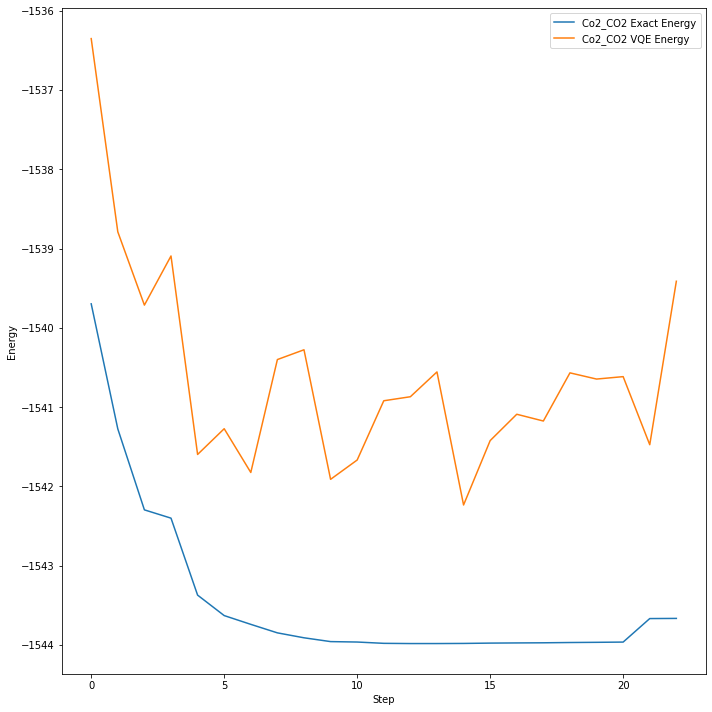

None

In [114]:
runVQEEnergies('Co2_CO2', 1,1,[59, 16, 12, 16], range(13,30))

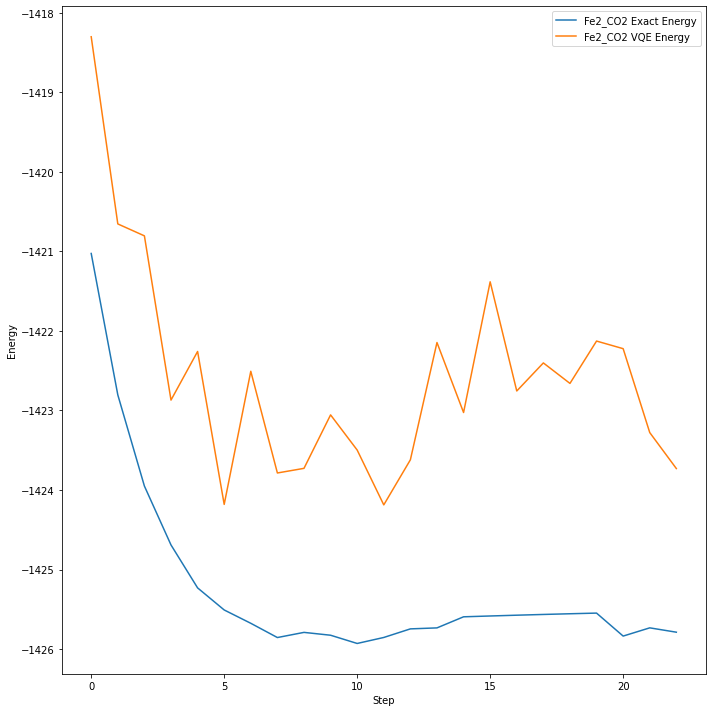

None

In [115]:
runVQEEnergies('Fe2_CO2', 1,2,[56, 16, 12, 16], range(13,30))

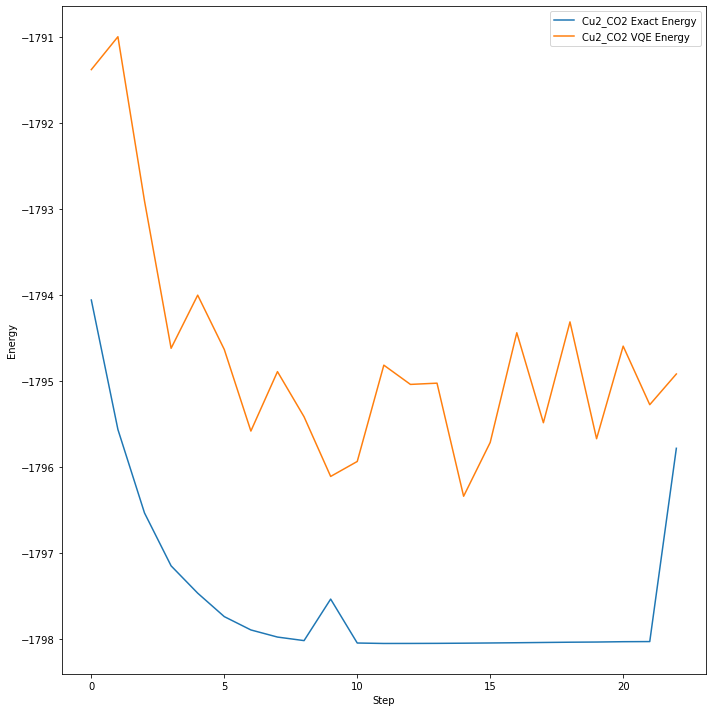

None

In [116]:
runVQEEnergies('Cu2_CO2', 1,1,[64, 16, 12, 16], range(13,30))

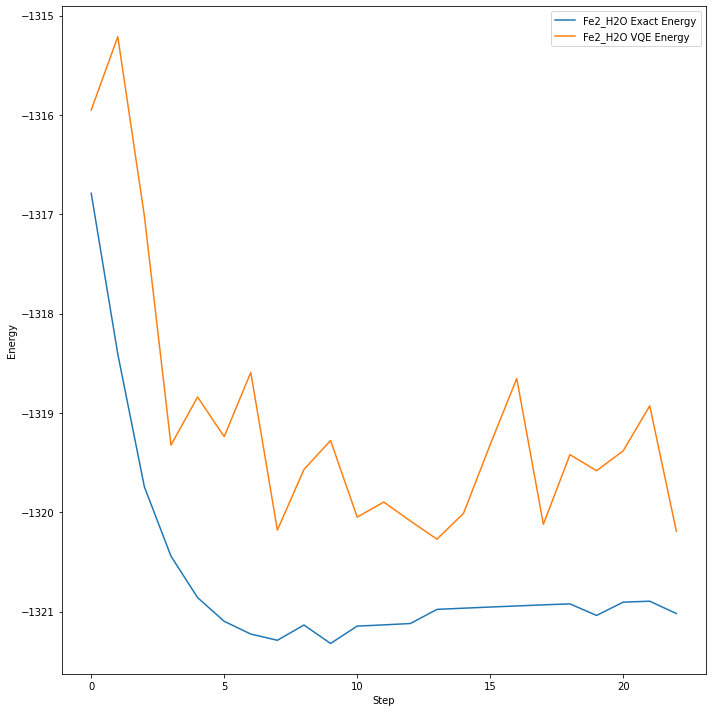

None

In [117]:
runVQEEnergies('Fe2_H2O', 1,2,[56, 1, 16, 1], range(13,30))

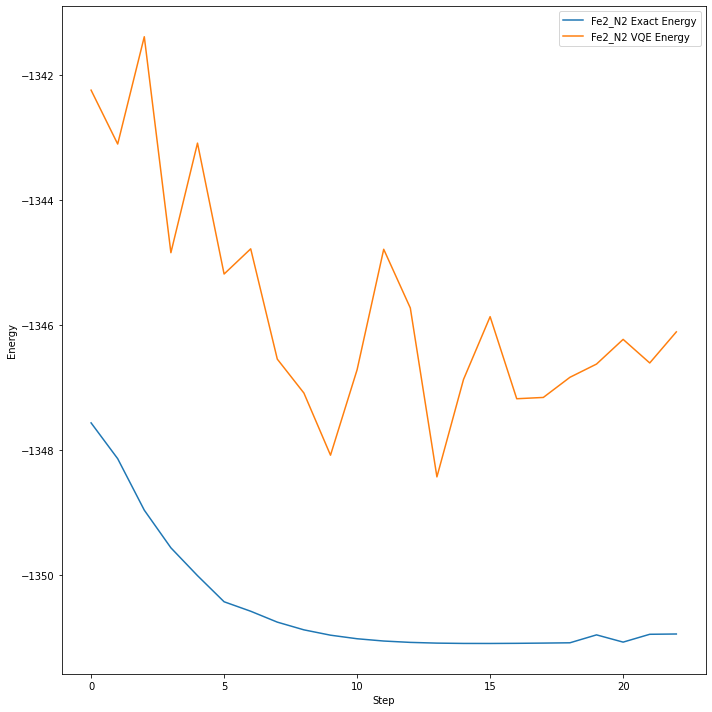

None

In [118]:
runVQEEnergies('Fe2_N2', 1,2,[56, 14, 14], range(16,34))

# Exact energy vs VQE Real quantum computer
Because of real QC long runtime we have only 1 round for the graph below.
With the small reduced problem size, the real QC run's energy is close to 0.

In [ ]:
runVQEEnergies('Co2_CO2', 1,1,[59, 16, 12, 16], range(13,32), True, 5, 'COBYLA')

# Exact energy vs Quantum Phase Estimation in noiseless simulation
By increasing the number of qubits the result's fidelity increases. Current report has 4 qubits.

In [ ]:
# ===
exact_energies = []
vqe_energies = []

steps = range(0,23)
for step in steps:
    #print("Starting step:", step, " VQE result:", vqe_energies)
    Co2_CO2 = get_coord(pth + r'/Co2_CO2.zip')
    mol, coords = getCoordinate(Co2_CO2, step, 4)

    gas_molecules = {
        'CoCO2': {'symbols': mol,
               'coords': coords,
               'multiplicity': 1,
               'charge': 1,
               'units': DistanceUnit.ANGSTROM,
               'masses': [59, 16, 12, 16],
               #'atom_pair': (1, 2), # not available after migration
               'fc_transformer': {
                   'fc_freeze_core': True, 
                   'fc_remove_orbitals': range(13,30),
                   },
    #           'as_transformer': {
    #               'as_num_electrons': 0,
    #               'as_num_spatial_orbitals': 2,
    #               'as_active_orbitals': [1, 1],
    #               }
               }
    }

    hyperparameters = {
        'CoCO2': {'reps': 2,
               'two_qubit_reduction': True,
               'z2symmetry_reduction': None,
               'backend': qasm_simulator, #qasm_simulator
               'ansatz': 'UCCSD',
               'initial_circuit': 'RealAmplitudes',
               'qpe_num_time_slices' : 1,
               'qpe_n_ancilliae': 3
              },

    }


    # ===
    molecule = gas_molecules['CoCO2']
    hyperparam = hyperparameters['CoCO2']
    optimizer = 'SPSA'
    # display_report = False
    display_dict = {}

    _, energy, display_df = get_construct_problem(input_value = gas_molecules['CoCO2'], hyperparam = hyperparameters['CoCO2'], 
                                                  input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                  basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                  solver_type = 'numpy_solver', method = 'gses', optimizer = optimizer,seed = _SEED)
    #print("Classical:", _, energy, display_df )
    exact_energies.append(energy)

    _, energy, display_df = get_construct_problem(input_value = gas_molecules['CoCO2'], hyperparam = hyperparameters['CoCO2'], 
                                                  input_type = 'molecule', display_report = False, reduced = 'FreezeCore', 
                                                  basis = 'sto3g', mapper_type = 'JordanWignerMapper', 
                                                  solver_type = 'numpy_solver', method = 'qpe', optimizer = optimizer,seed = _SEED)
    #print("Quantum mechanic:", _, energy, display_df )
    vqe_energies.append(energy)


In [ ]:
molecule_name = "Co2_CO2"
plt.plot(steps, exact_energies, label=molecule_name + " Exact Energy")
plt.plot(steps, vqe_energies, label=molecule_name + " QPE Energy")
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
display(plt.show())

# Unittest for molecule energy from BOPES distances

In [ ]:
# ===
gas_molecules = {
    'h2': {'symbols': ["H", "H"],
           'coords': [(0.0000, 0.0000, 0.0000),
                      (0.0000, 0.0000, 0.7414)],
           'multiplicity': 1,
           'charge': 0,
           'units': DistanceUnit.ANGSTROM,
           'masses': [1, 1],
           # 'atom_pair': (1, 2), # not available after migration
           'fc_transformer': {
               'fc_freeze_core': True, 
               'fc_remove_orbitals': None,
               },
           'as_transformer': {
               'as_num_electrons': 0,
               'as_num_spatial_orbitals': 2,
               'as_active_orbitals': [1, 1],
               }
           }
}

hyperparameters = {
    'h2': {'reps': 2,
           'two_qubit_reduction': True,
           'z2symmetry_reduction': 'auto',
           'perturbation_steps': np.linspace(0.5, 4.0, 250),
           'qpe_num_time_slices': 1,
           'qpe_n_ancilliae': 3,
           'atom_pair': (1, 2), # index start from 1
           'optimizer': 'SLSQP',
           'ansatz': 'UCCSD',
           'initial_circuit': 'PauliTwoDesign',
          },

}

solution_master = {
    'classical': ['numpy_solver', 'numpy_solver_with_filter'],
    'quantum': ['vqe_qnspsa', 'vqe_runtime', 'vqe_runtime_with_noise', 'vqe_ansatz', 'vqe_ansatz', 'vqe_initial_circuit']
}

# ===
input_value = gas_molecules['h2']
hyperparam = hyperparameters['h2']
input_type = 'molecule'
display_report = True
display_dict = {}
reduced = 'FreezeCore'
basis = 'sto3g'
mapper_type = 'JordanWignerMapper'
solver_type = 'numpy_solver'
method = 'gses'
optimizer = 'SPSA'
seed = _SEED

In [ ]:
_, energy, display_df = get_construct_problem(input_value, hyperparam, input_type, display_report, reduced, basis, mapper_type, solver_type, method, optimizer, seed)
display_df

In [ ]:
perturb_steps, energy_lst = get_a_molecule_bopes(input_value = gas_molecules['h2'], hyperparam = hyperparameters['h2'], input_type = 'molecule',
                                               reduced = 'FreezeCore', basis = 'sto3g', mapper_type = 'JordanWignerMapper', solver_type = 'numpy_solver', method = 'gses', 
                                               perturbation_steps = np.linspace(0.5, 3.0, 250), optimizer = optimizer, display_report = True, seed = _SEED)

# Additional Molecular data

In [ ]:
gas_molecules = {
    'h2': {'symbols': ["H", "H"],
           'coords': [(0.0000, 0.0000, 0.0000),
                      (0.0000, 0.0000, 0.7414)],
           'multiplicity': 1,
           'charge': 0,
           'units': DistanceUnit.ANGSTROM,
           'masses': [1, 1],
           'atom_pair': (1, 2),
           'fc_transformer': {
               'fc_freeze_core': True, 
               'fc_remove_orbitals': None,
               },
           'as_transformer': {
               'as_num_electrons': 0,
               'as_num_spatial_orbitals': 2,
               'as_active_orbitals': [1, 1],
               }
           },
    'n2': {'symbols': ["N", "N"],
           'coords': [(0.0000, 0.0000, 0.5488), 
                      (0.0000, 0.0000, -0.5488)],
           'multiplicity': 4,
           'charge': 0,
           'units': DistanceUnit.ANGSTROM,
           'masses': [7, 7],
           'atom_pair': (1, 2),
           'fc_transformer': {
               'fc_freeze_core': True, 
               'fc_remove_orbitals': None,
               },
           'as_transformer': {
               'as_num_electrons': 0,
               'as_num_spatial_orbitals': 2,
               'as_active_orbitals': [1, 1],
               }
           
           
           },
    'co2': {'symbols': ["C", "O", "O"],
            'coords': [(0.0000, 0.0000, 0.0000),
                       (0.0000, 0.0000, 1.1621),
                       (0.0000, 0.0000, -1.1621)],
            'multiplicity': 2,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 8, 8],
            'atom_pair': (1, 2)
           },
    'h2o': {'symbols': ["O", "H", "H"],
            'coords': [(0.0000, 0.0000, 0.1173),
                       (0.0000, 0.7572, -0.4692),
                       (0.0000, -0.7572, -0.4692)],
            'multiplicity': 1,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 8, 8],
            'atom_pair': (1, 2)
           },
    'so2': {'symbols': ["S", "O", "O"],
            'coords': [(0.0000, 0.0000, 0.0000),
                       (0.0000, 1.2371, 0.7215),
                       (0.0000, -1.2371, 0.7215)],
            'multiplicity': 1,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 8, 8],
            'atom_pair': (1, 2)
           },
    'no2': {'symbols': ["N", "O", "O"],
            'coords': [(0.0000, 0.0000, 0.0000),
                       (0.0000, 1.0989, 0.4653),
                       (0.0000, -1.0989, 0.4653)],
            'multiplicity': 2,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 8, 8],
            'atom_pair': (1, 2)
           },
    'n2o': {'symbols': ["N", "N", "O"],
            'coords': [(0.0000, 0.0000, -1.1998),
                       (0.0000, 0.7572, -0.0716),
                       (0.0000, -0.7572, 1.126)],
            'multiplicity': 1,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 8, 8],
            'atom_pair': (1, 2)
           },
    'ch4': {'symbols': ["C", "H", "H", "H", "H"],
            'coords': [(0.0000, 0.0000, 0.0000), 
                       (0.6276, 0.6276, 0.6276),
                       (0.6276, -0.6276, -0.6276),
                       (-0.6276, 0.6276, -0.6276),
                       (0.6276, -0.6276, 0.6276)],
            'multiplicity': 1,
            'charge': 0,
            'units': DistanceUnit.ANGSTROM,
            'masses': [12, 1, 1, 1, 1],
            'atom_pair': (1, 4)
           },
    

}

# Not updated
# Spin multiplicity check SO2, N2O, CH4
